In [1]:
from os import path
import time

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline

from numpy.lib.recfunctions import stack_arrays
import glob

from pyia import GaiaData

import gala.coordinates as gc

import dustmaps
from dustmaps.sfd import SFDQuery

import dustmaps.sfd
dustmaps.sfd.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [2]:
from sfd import ebv, reddening

# NOTE!

Gap and underdensity coordinates made up!

In [20]:
gap1_phi1 = coord.Angle([-24., -18]*u.deg)
gap2_phi1 = coord.Angle([-8, -2]*u.deg)
udens_phi1 = coord.Angle([-44, -36]*u.deg)

In [4]:
# t = Table.read('../data/gd1-all-ps1.fits') # to add reddening below
t = Table.read('../data/gd1-all-ps1-red.fits')
g = GaiaData(t)

In [5]:
gd1_c = coord.SkyCoord(ra=g.ra, dec=g.dec)
gd1_gal = gd1_c.galactic
ecl = gd1_c.transform_to(coord.BarycentricTrueEcliptic)

In [6]:
# phi1s = np.arange(-120, 60+1, 15)
# phi2s = np.arange(-90, 90+1, 15)

# npts = 128
# gridlines = []
# for phi1 in phi1s:
#     gridlines.append([np.ones(npts)*phi1, np.linspace(-90, 90, npts)])
# for phi2 in phi2s:
#     gridlines.append([np.linspace(-180, 180, npts), np.ones(npts)*phi2])
    
# gridlines = np.array(gridlines) * u.deg

phi1s = np.arange(-120, 60+1, 15)
phi2s = np.arange(-10, 10+1, 5)

npts = 128
gridlines = []
for phi1 in phi1s:
    gridlines.append([np.ones(npts)*phi1, np.linspace(-10, 10, npts)])
for phi2 in phi2s:
    gridlines.append([np.linspace(-120, 60, npts), np.ones(npts)*phi2])
    
gridlines = np.array(gridlines) * u.deg

gd1_grid_c = coord.SkyCoord(gc.GD1(phi1=gridlines[:, 0], phi2=gridlines[:, 1]))

---

# Add SFD reddening

In [7]:
# R = reddening(gd1_c, 'PS1', 'grizy')

In [8]:
# R_tbl = Table()
# R_tbl['A_g'] = R[:, 0]
# R_tbl['A_r'] = R[:, 1]
# R_tbl['A_i'] = R[:, 2]
# R_tbl['A_z'] = R[:, 3]
# R_tbl['A_y'] = R[:, 4]

# t2 = hstack((t, R_tbl))

In [9]:
# t2.write('../data/gd1-all-ps1-red.fits')

---

Text(0,0.5,'$b$ [deg]')

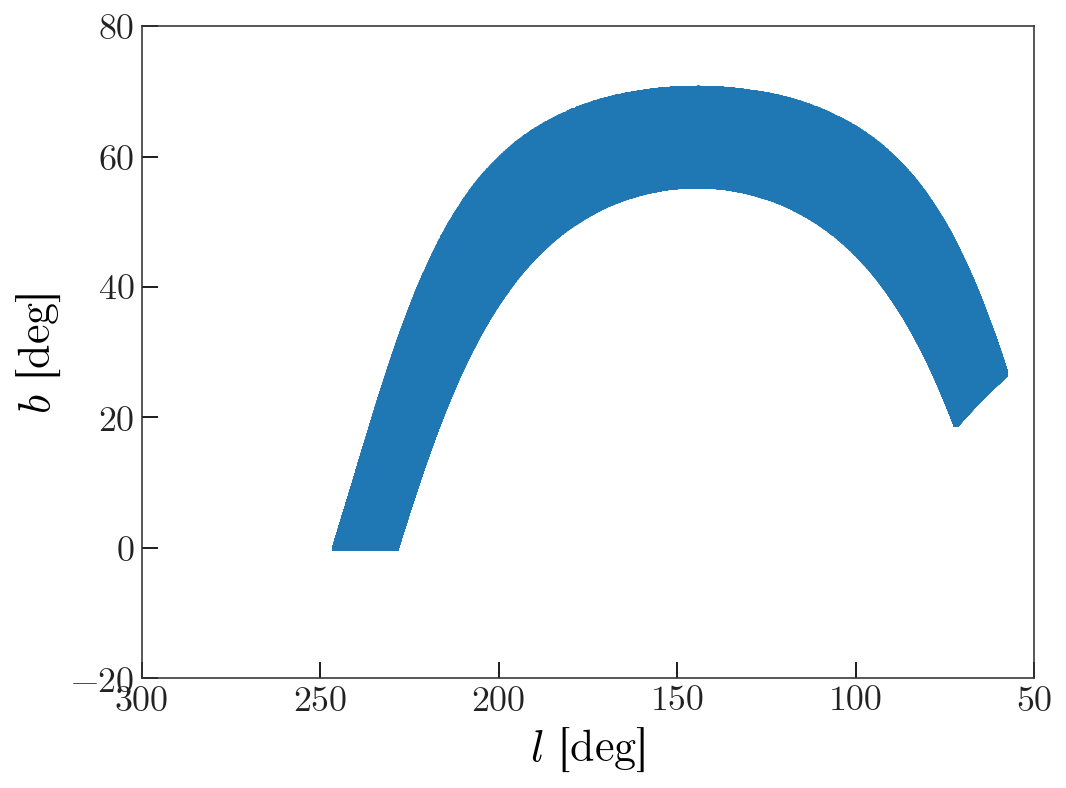

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(gd1_gal.l.degree, gd1_gal.b.degree, marker='.', linestyle='none')
ax.set_xlim(300, 50)
ax.set_ylim(-20, 80)
ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')

Text(0,0.5,'$b_{\\rm ecl}$ [deg]')

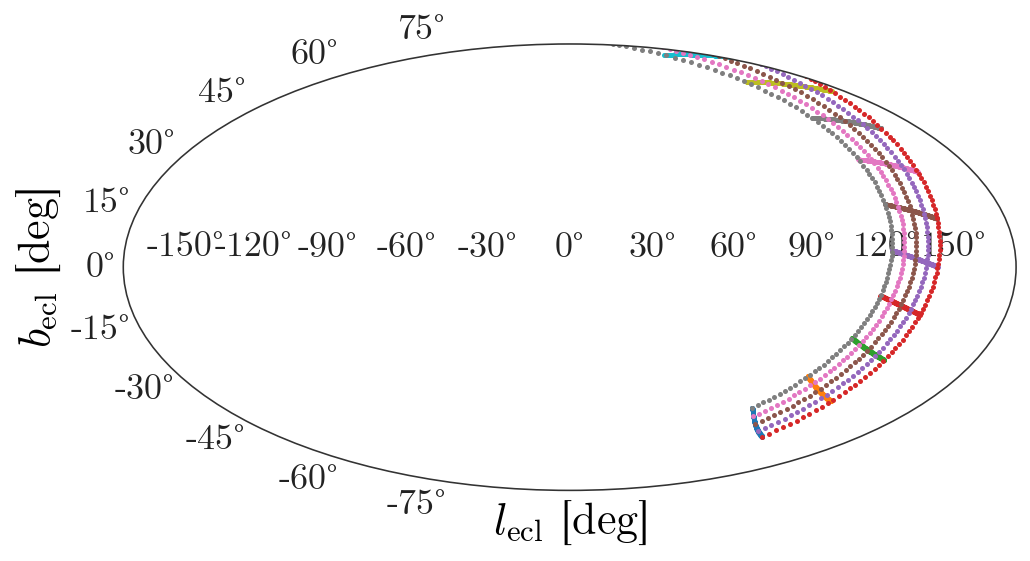

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw=dict(projection='hammer'))

grid_ecl = gd1_grid_c.transform_to(coord.BarycentricTrueEcliptic)
for i in range(grid_ecl.shape[0]):
    ax.plot(grid_ecl[i].lon.wrap_at(360*u.deg).radian, 
            grid_ecl[i].lat.radian, 
            marker='.', linestyle='none')

# ax.plot(ecl.lon.degree[::100], ecl.lat.degree[::100], 
#         marker='.', linestyle='none')
# ax.set_xlim(300, 50)
# ax.set_ylim(-20, 80)
# ax.set_xlim(180, -180)
ax.set_xlabel(r'$l_{\rm ecl}$ [deg]')
ax.set_ylabel(r'$b_{\rm ecl}$ [deg]')

In [12]:
l = np.arange(50, 250, 0.1)
b = np.arange(-10, 80, 0.1)
l, b = np.meshgrid(l, b)
coords = coord.SkyCoord(l*u.deg, b*u.deg,
                        distance=1.*u.kpc, frame='galactic')

In [13]:
sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coords)

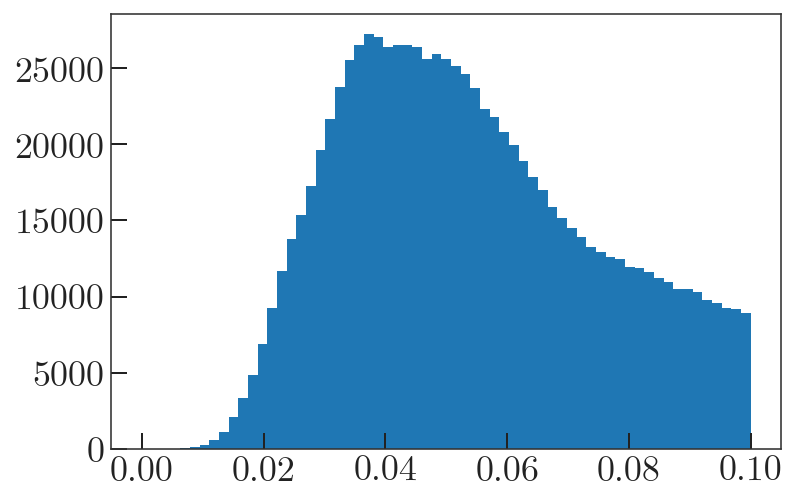

In [14]:
plt.hist(Av_sfd.ravel(), bins=np.linspace(0, 0.1, 64));

In [15]:
phi1 = np.linspace(-100, 50, 1024) * u.degree
phi2 = np.full(len(phi1), 1) * phi1.unit
gd1_hull1 = gc.GD1(phi1=phi1, phi2=phi2).transform_to(coord.Galactic)

phi2 = np.full(len(phi1), -1) * phi1.unit
gd1_hull2 = gc.GD1(phi1=phi1, phi2=phi2).transform_to(coord.Galactic)

gd1_gap1 = gc.GD1(phi1=[338, 338, 342, 342]*u.deg, 
                  phi2=[-1, 1, -1, 1]*u.deg).transform_to(coord.Galactic)
gd1_gap2 = gc.GD1(phi1=[353, 358, 358, 353]*u.deg, 
                  phi2=[-1, 1, -1, 1]*u.deg).transform_to(coord.Galactic)
gd1_underd = gc.GD1(phi1=[316, 316, 324, 324]*u.deg, 
                    phi2=[-1, 1, -1, 1]*u.deg).transform_to(coord.Galactic)

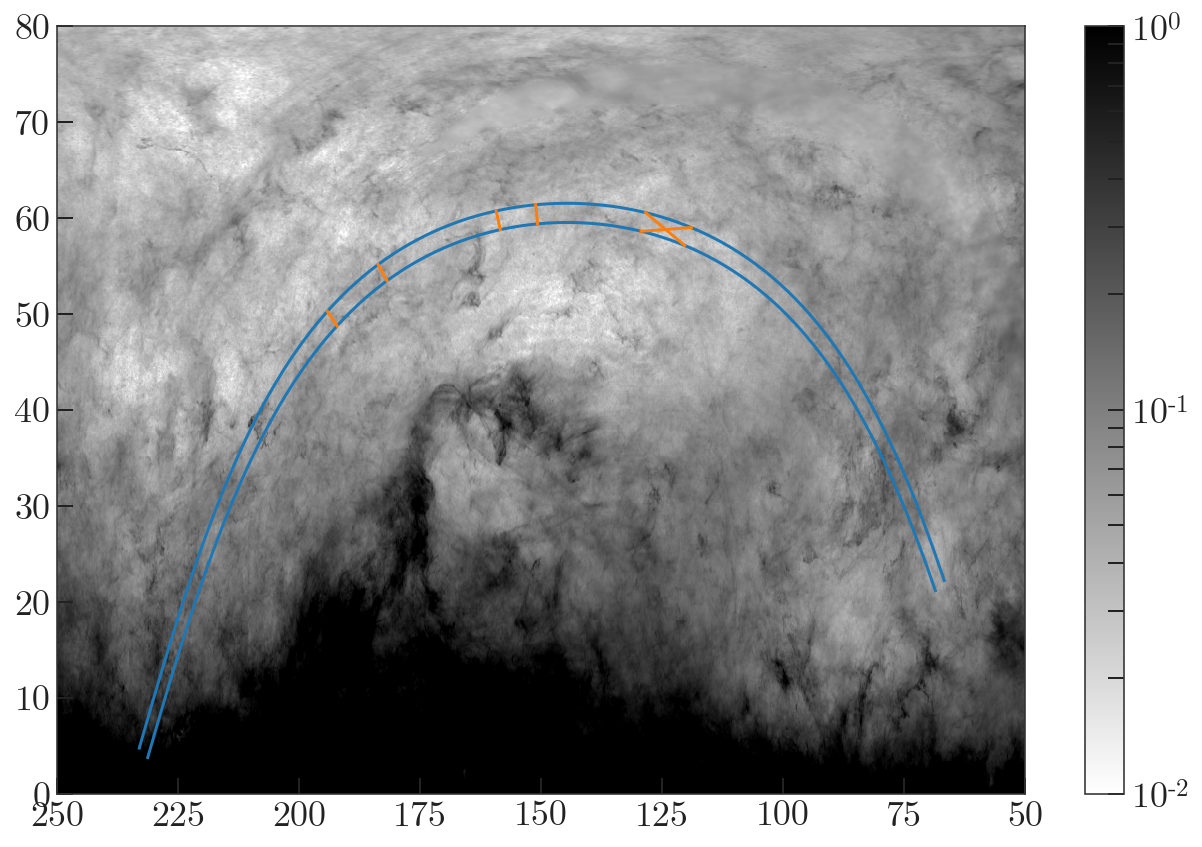

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# ax.pcolormesh(l, b, 
#    Av_sfd[::,::-1],
#    vmin=0.,
#    vmax=4.,
#    cmap='binary'
# )
c = ax.pcolormesh(l, b, 
   Av_sfd[::,::-1],
   cmap='binary',
   norm=mpl.colors.LogNorm(vmin=1E-2, vmax=1e0)
)

ax.plot(gd1_hull1.l.degree, gd1_hull1.b.degree, 
        marker='', color='tab:blue')
ax.plot(gd1_hull2.l.degree, gd1_hull2.b.degree, 
        marker='', color='tab:blue')

ax.plot(gd1_gap1.l.degree[:2], gd1_gap1.b.degree[:2], 
        marker='', color='tab:orange')
ax.plot(gd1_gap1.l.degree[2:], gd1_gap1.b.degree[2:], 
        marker='', color='tab:orange')

ax.plot(gd1_gap2.l.degree[:2], gd1_gap2.b.degree[:2], 
        marker='', color='tab:orange')
ax.plot(gd1_gap2.l.degree[2:], gd1_gap2.b.degree[2:], 
        marker='', color='tab:orange')

ax.plot(gd1_underd.l.degree[:2], gd1_underd.b.degree[:2], 
        marker='', color='tab:orange')
ax.plot(gd1_underd.l.degree[2:], gd1_underd.b.degree[2:], 
        marker='', color='tab:orange')

ax.set_xlim(250, 50)
ax.set_ylim(0, 80)

fig.colorbar(c)

fig.tight_layout()

---

GD1 coordinates

In [18]:
l = np.arange(-100, 50, 0.1)
b = np.arange(-10., 5., 0.1)
l, b = np.meshgrid(l, b)
l = coord.Angle(l*u.deg)
b = coord.Angle(b*u.deg)
coords = coord.SkyCoord(l, b,
                        distance=1.*u.kpc, frame=gc.GD1)

sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coords)

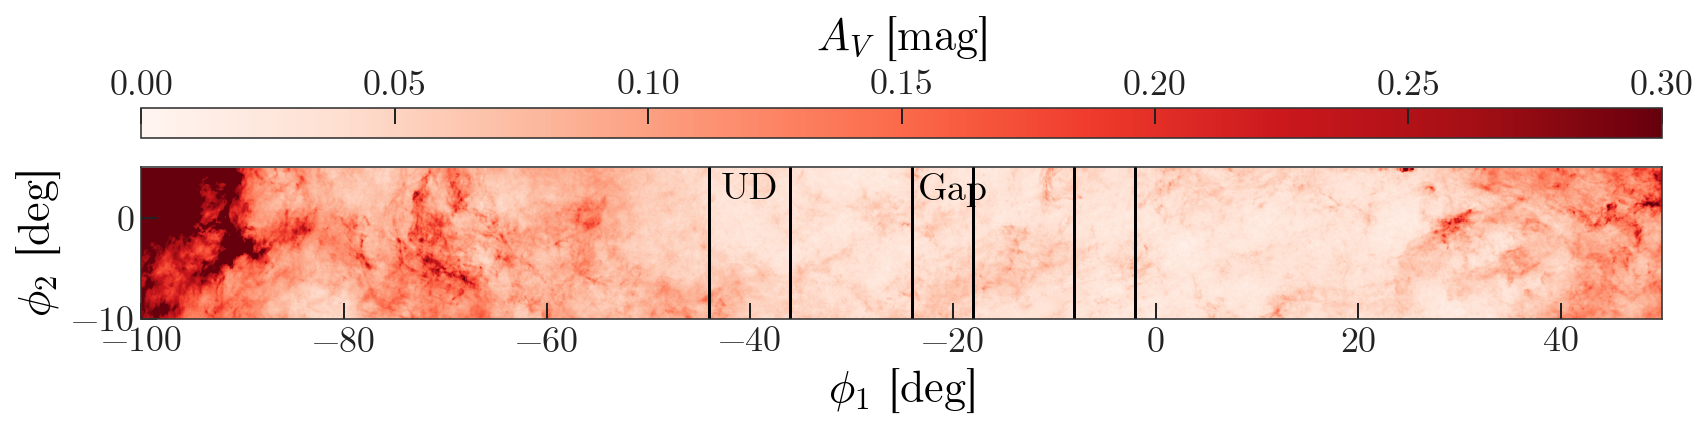

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

l_ = l.wrap_at(180*u.deg).degree
c = ax.pcolormesh(l_, b.degree, 
   Av_sfd,
   cmap='Reds',
   norm=mpl.colors.Normalize(vmin=0, vmax=0.3),
   rasterized=True
)

for v in gap1_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in gap2_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in udens_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')

div = make_axes_locatable(ax)
cax = div.append_axes("top", size="20%", pad=0.2)
cb = fig.colorbar(c, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')

cb.set_label('$A_V$ [mag]', labelpad=10)
cb.ax.xaxis.set_label_position('top')

ax.set_xlim(l_.min(), l_.max())
ax.set_ylim(-10, 5)

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

ax.text(-40, 4.5, 'UD', ha='center', va='top', fontsize=19)
ax.text(-20, 4.5, 'Gap', ha='center', va='top', fontsize=19)

fig.tight_layout()
ax.set_aspect('equal')

# fig.savefig('../paper/sfd.pdf', dpi=250)

0.026093036 0.039676607


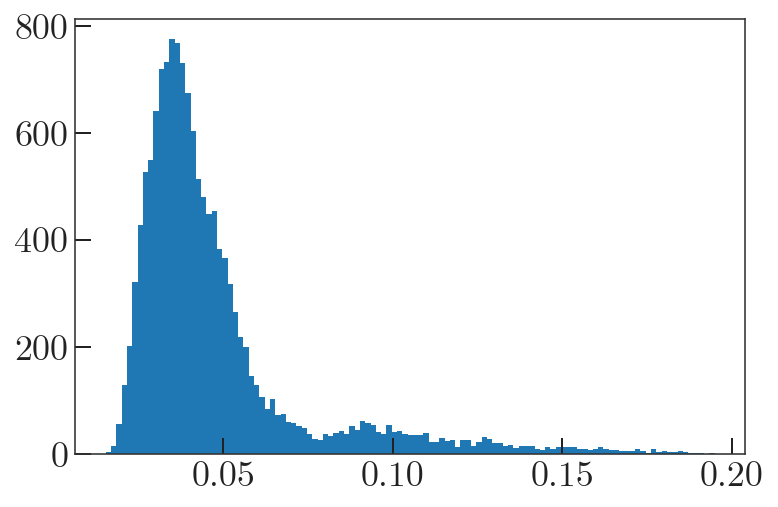

In [26]:
l = np.arange(-60, 10, 0.1)
b = np.arange(-1, 1, 0.1)
l, b = np.meshgrid(l, b)
l = coord.Angle(l*u.deg)
b = coord.Angle(b*u.deg)
coords = coord.SkyCoord(l, b, distance=1.*u.kpc, 
                        frame=gc.GD1)
sfd = SFDQuery()
A_V = 2.742 * sfd(coords)
print(np.std(A_V), np.median(A_V.ravel()))

plt.hist(A_V.ravel(), bins='auto');

In [22]:
for region in [gap_phi1, udens_phi1]:
    l = np.arange(region.min().value, region.max().value, 0.1)
    b = np.arange(-1, 1, 0.1)
    l, b = np.meshgrid(l, b)
    l = coord.Angle(l*u.deg)
    b = coord.Angle(b*u.deg)
    coords = coord.SkyCoord(l, b, distance=1.*u.kpc, 
                            frame=gc.GD1)

    sfd = SFDQuery()
    print(np.max(2.742 * sfd(coords)))

0.07778956
0.06353467


## Compute $u$ parameter from Lindegren:

$$
u = \sqrt{\chi^2 / \nu}\\
\chi^2 = \texttt{astrometric_chi2_al}\\
\nu = \texttt{astrometric_n_good_obs_al} - 5
$$

Unit weight error:

In [48]:
q_u_base ='''SELECT source_id, ra, dec, astrometric_chi2_al, astrometric_n_good_obs_al, phot_g_mean_mag 
FROM gaiadr2.gaia_source
WHERE CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0.ra.degree}, {0.dec.degree}, 
                       {1.ra.degree}, {1.dec.degree}, 
                       {2.ra.degree}, {2.dec.degree}, 
                       {3.ra.degree}, {3.dec.degree})) = 1 AND
    phot_g_mean_mag > 17.5 AND bp_rp > 0 AND bp_rp < 1.3

'''

queries = []
for l in np.arange(-100, 30, 10):
    corners = gc.GD1(phi1=[l, l, l+10, l+10]*u.deg, 
                     phi2=[-10, 5, 5, -10]*u.deg)
    corners_icrs = corners.transform_to(coord.ICRS)
    q = q_u_base.format(corners_icrs[0], corners_icrs[1], corners_icrs[2], corners_icrs[3])
    
    fn = '../data/unitweight/{0}.fits'.format(l)
    
    if not path.exists(fn):
        gg = GaiaData.from_query(q)
        gg.data.write(fn)
        time.sleep(1.)
        del gg
    else:
        print(fn + ' already exists')

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.


In [49]:
all_uw_filename = '../data/unitweight-all.fits'
if not path.exists(all_uw_filename):
    arrs = []
    for filename in glob.glob('../data/unitweight/*.fits'):
        arrs.append(np.array(fits.getdata(filename)))
    arr = stack_arrays(arrs, asrecarray=True, usemask=False)
    t_ = Table(arr)
    t_.write(all_uw_filename)

In [76]:
t_u = Table.read(all_uw_filename)
c_u = coord.SkyCoord(ra=t_u['ra']*u.deg, dec=t_u['dec']*u.deg)
c_u_gd1 = c_u.transform_to(gc.GD1)

In [77]:
chi2 = t_u['astrometric_chi2_al']
nu = t_u['astrometric_n_good_obs_al'] - 5
unit_weight = np.sqrt(chi2 / nu)

comp = 1.2 * np.max([np.ones(len(t_u)), np.array(np.exp(-0.2 * (t_u['phot_g_mean_mag'] - 19.5)))], axis=0)

norm_unit_weight = unit_weight / comp

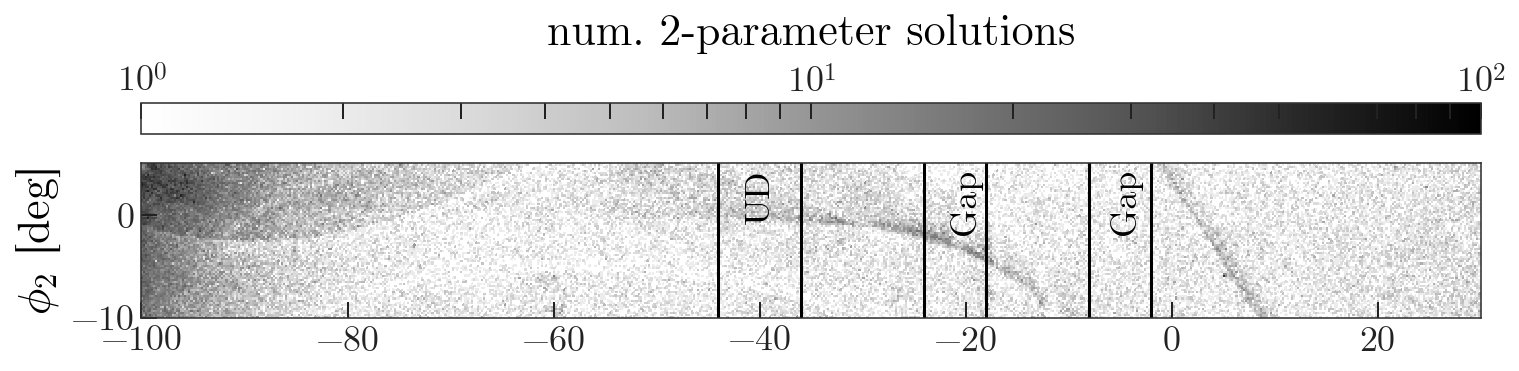

In [87]:
H, xe, ye = np.histogram2d(c_u_gd1.phi1.wrap_at(180*u.deg).degree[norm_unit_weight > 1],
                           c_u_gd1.phi2.degree[norm_unit_weight > 1], 
                           bins=(lbins, bbins))

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

lbins = np.arange(-120, 50+1e-3, 0.2)
bbins = np.arange(-10, 5+1e-3, 0.2)

# c = ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T, 
#                   norm=mpl.colors.Normalize(vmin=0.5, vmax=1),
#                   cmap='Greys', rasterized=True)

c = ax.pcolormesh(xe, ye, H.T,
                  norm=mpl.colors.LogNorm(vmin=1, vmax=100),
                  cmap='Greys', rasterized=True)

for v in gap1_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in gap2_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in udens_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')

div = make_axes_locatable(ax)
cax = div.append_axes("top", size="20%", pad=0.2)
cb = fig.colorbar(c, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')

cb.set_label('num. 2-parameter solutions', labelpad=10)
cb.ax.xaxis.set_label_position('top')

ax.set_xlim(-100, 30)
ax.set_ylim(-10, 5)

# ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

ax.set_aspect('equal')

---

### Queries to check the scanning law

In [4]:
q_2par_base ='''SELECT ra, dec FROM gaiadr2.gaia_source
WHERE parallax IS NULL AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0.ra.degree}, {0.dec.degree}, 
                       {1.ra.degree}, {1.dec.degree}, 
                       {2.ra.degree}, {2.dec.degree}, 
                       {3.ra.degree}, {3.dec.degree})) = 1
'''

In [7]:
queries = []
for l in np.arange(-100, 30, 10):
    corners = gc.GD1(phi1=[l, l, l+10, l+10]*u.deg, 
                     phi2=[-10, 5, 5, -10]*u.deg)
    corners_icrs = corners.transform_to(coord.ICRS)
    q = q_2par_base.format(corners_icrs[0], corners_icrs[1], corners_icrs[2], corners_icrs[3])
    
    fn = '../data/twopar/{0}.fits'.format(l)
    
    if not path.exists(fn):
        gg = GaiaData.from_query(q)
        gg.data.write(fn)
        time.sleep(1.)
        del gg
    else:
        print(fn + ' already exists')

../data/twopar/-120.fits already exists
Launched query: 'SELECT ra, dec FROM gaiadr2.gaia_source
WHERE parallax IS NULL AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       119.78295147242953, -28.62925471796404, 
                       105.70841891081587, -20.75275339914417, 
                       111.39341430156357, -12.408913634684538, 
                       124.90645851283158, -19.955203131285998)) = 1
'
Retrieving async. results...


Query finished.
Launched query: 'SELECT ra, dec FROM gaiadr2.gaia_source
WHERE parallax IS NULL AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       124.90645851283158, -19.955203131285998, 
                       111.39341430156357, -12.408913634684538, 
                       116.59156945722076, -3.875916644770994, 
                       129.75957571032393, -11.284309755448882)) = 1
'
Retrieving async. results...
Query finished.
Launched query: 'SELECT ra, dec FROM gaiadr2.gaia_source
WHERE parallax IS NULL AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       129.75957571032393, -11.284309755448882, 
                       116.59156945722076, -3.875916644770994, 
                       121.55418932787543, 4.764630672532538, 
                       134.58828370034513, -2.6790431755558206)) = 1
'
Retrieving async. results...
Query finished.
Launched query: 'SELECT ra, dec FROM gaiadr2.gaia_sour

Combine tables:

In [25]:
all_filename = '../data/twopar-all.fits'
if not path.exists(all_filename):
    arrs = []
    for filename in glob.glob('../data/twopar/*.fits'):
        arrs.append(np.array(fits.getdata(filename)))
    arr = stack_arrays(arrs, asrecarray=True, usemask=False)
    t_ = Table(arr)
    t_.write(all_filename)

In [26]:
t_2par = Table.read(all_filename)
c_2par = coord.SkyCoord(ra=t_2par['ra']*u.deg, dec=t_2par['dec']*u.deg)
c_2par_gd1 = c_2par.transform_to(gc.GD1)

---

# The Figure

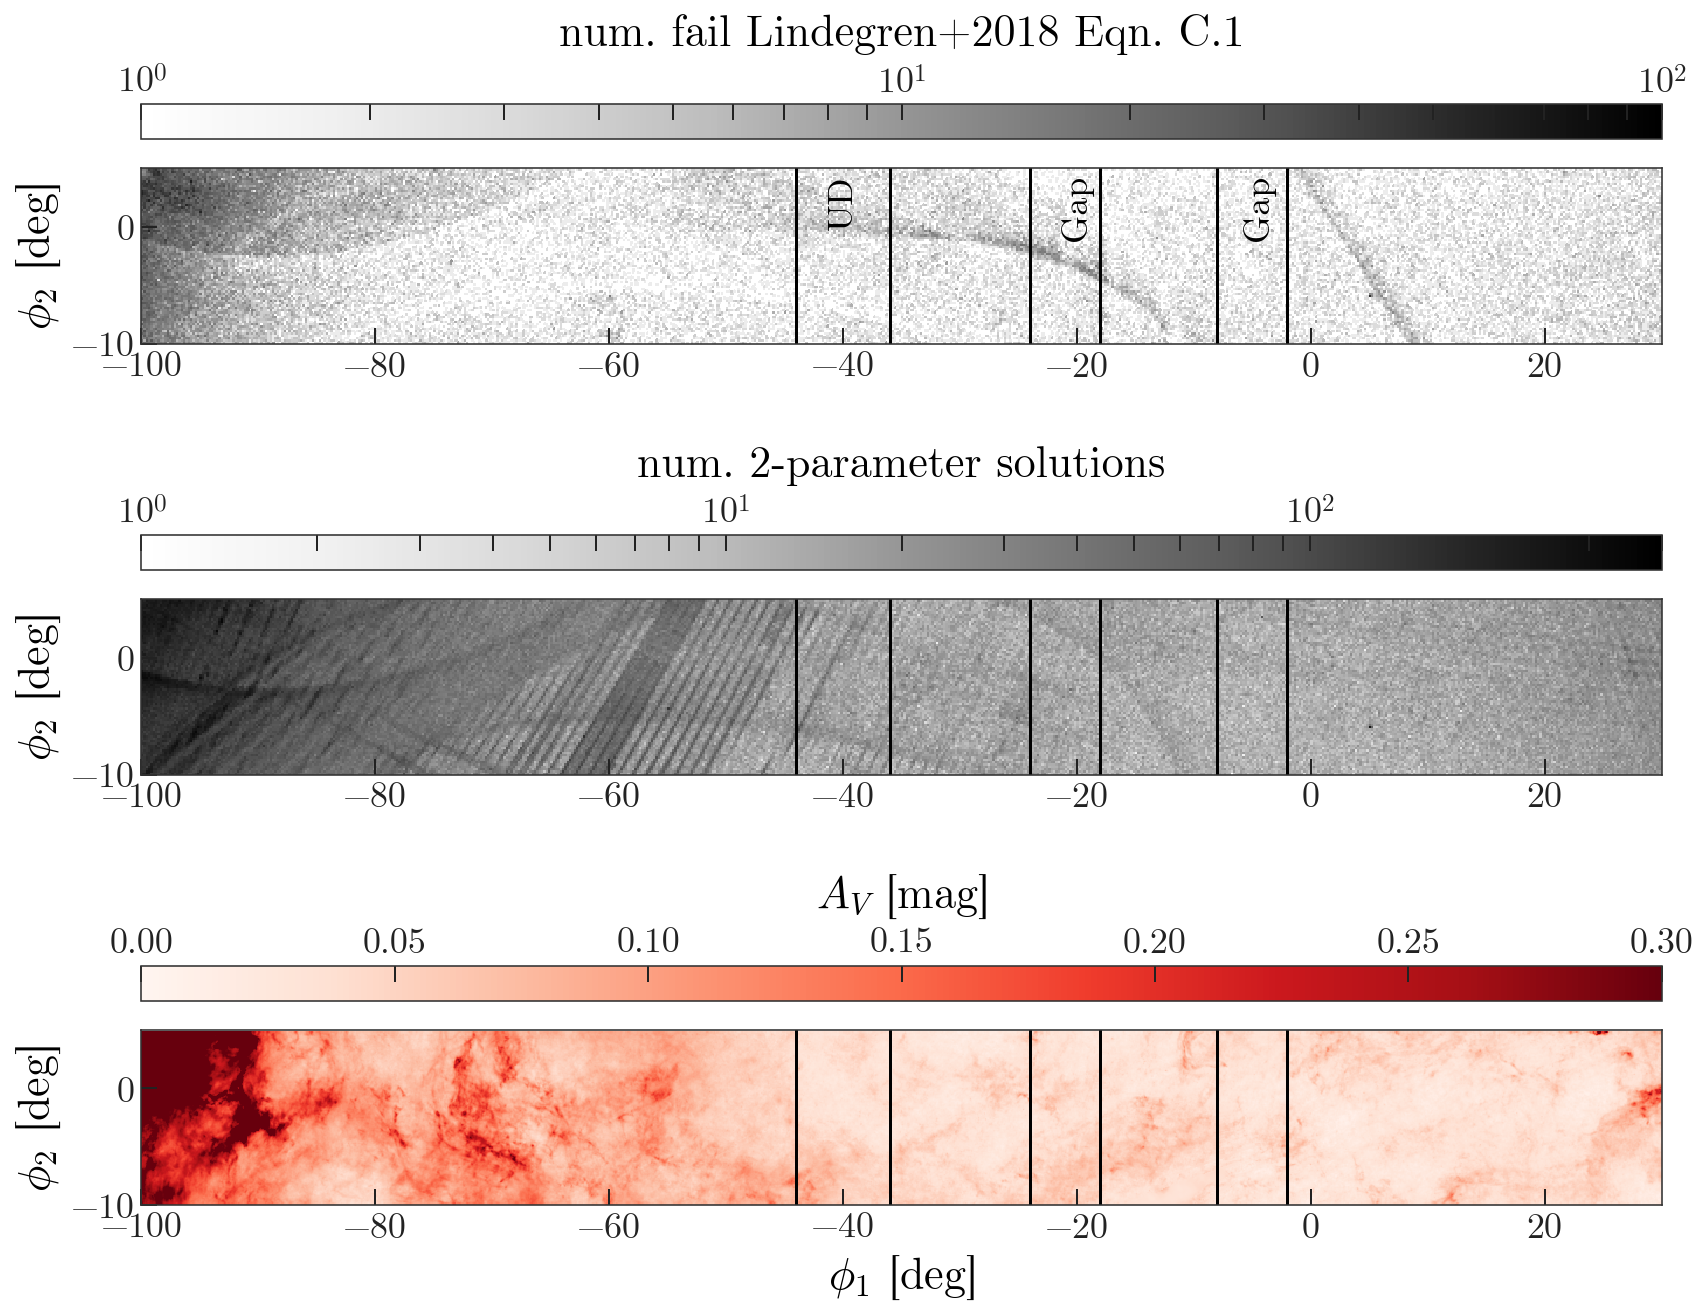

In [94]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharey=True)

lbins = np.arange(-120, 50+1e-3, 0.2)
bbins = np.arange(-10, 5+1e-3, 0.2)

# --- unit weight error ---

ax = axes[0]

H, xe, ye = np.histogram2d(c_u_gd1.phi1.wrap_at(180*u.deg).degree[norm_unit_weight > 1],
                           c_u_gd1.phi2.degree[norm_unit_weight > 1], 
                           bins=(lbins, bbins))

# c = ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T, 
#                   norm=mpl.colors.Normalize(vmin=0.5, vmax=1),
#                   cmap='Greys', rasterized=True)

c = ax.pcolormesh(xe, ye, H.T,
                  norm=mpl.colors.LogNorm(vmin=1, vmax=100),
                  cmap='Greys', rasterized=True)

for v in gap1_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in gap2_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in udens_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')

div = make_axes_locatable(ax)
cax = div.append_axes("top", size="20%", pad=0.2)
cb = fig.colorbar(c, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')

cb.set_label('num. fail Lindegren+2018 Eqn. C.1', labelpad=10)
cb.ax.xaxis.set_label_position('top')

# ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

ax.text(-40, 4.5, 'UD', ha='center', va='top', fontsize=18, rotation=90)
ax.text(-20, 4.5, 'Gap', ha='center', va='top', fontsize=18, rotation=90)
ax.text(-4.5, 4.5, 'Gap', ha='center', va='top', fontsize=18, rotation=90)


# --- 2-parameter solutions ---

ax = axes[1]
H, xe, ye = np.histogram2d(c_2par_gd1.phi1.wrap_at(180*u.deg).degree,
                           c_2par_gd1.phi2.degree, bins=(lbins, bbins))

c = ax.pcolormesh(xe, ye, H.T, 
                  norm=mpl.colors.LogNorm(vmin=1, vmax=400),
                  cmap='Greys', rasterized=True)

for v in gap1_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in gap2_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in udens_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')

div = make_axes_locatable(ax)
cax = div.append_axes("top", size="20%", pad=0.2)
cb = fig.colorbar(c, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')

cb.set_label('num. 2-parameter solutions', labelpad=10)
cb.ax.xaxis.set_label_position('top')

ax.set_xlim(xe.min(), xe.max())
ax.set_ylim(-10, 5)

# ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

# --- SFD ---

ax = axes[2]

l = np.arange(-100, 50, 0.1)
b = np.arange(-10., 5., 0.1)
l, b = np.meshgrid(l, b)
l = coord.Angle(l*u.deg)
b = coord.Angle(b*u.deg)
coords = coord.SkyCoord(l, b,
                        distance=1.*u.kpc, frame=gc.GD1)

sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coords)

l_ = l.wrap_at(180*u.deg).degree
c = ax.pcolormesh(l_, b.degree, 
   Av_sfd,
   cmap='Reds',
   norm=mpl.colors.Normalize(vmin=0, vmax=0.3),
   rasterized=True
)

for v in gap1_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in gap2_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in udens_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')

div = make_axes_locatable(ax)
cax = div.append_axes("top", size="20%", pad=0.2)
cb = fig.colorbar(c, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')

cb.set_label('$A_V$ [mag]', labelpad=10)
cb.ax.xaxis.set_label_position('top')

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlim(-100, 30)

fig.tight_layout()
fig.subplots_adjust(hspace=0.6)

fig.savefig('../paper/dust-2par.pdf', dpi=200)

---

Download full data for a few patches to measure source density

In [33]:
gc.GD1(phi1=[-40, -20, 0]*u.deg, phi2=0*u.deg).transform_to(coord.ICRS)

<ICRS Coordinate: (ra, dec) in deg
    [( 149.14444016,  36.02957018), ( 168.38247435,  50.46227709),
     ( 200.        ,  59.4504341 )]>

Source density at these points is: 2673, 2500, 2843 per deg^2